# How to control graph recursion limit

You can set the graph recursion limit when invoking or streaming the graph. The recursion limit sets the number of supersteps that the graph is allowed to execute before it raises an error. Read more about the concept of recursion limits [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#recursion-limit). Let's see an example of this in a simple graph with parallel branches to better understand exactly how the recursion limit works.

## Setup

First, let's install the required packages

In [ ]:
%%capture --no-stderr
%pip install -U langgraph

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Define the graph

In [1]:
import operator
from typing import Annotated, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

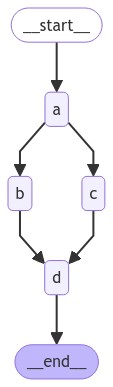

In [2]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

As we can see, our graph will execute nodes `b` and `c` in parallel (i.e. in a single super-step), which means that if we run this graph it should take exactly 3 steps. We can set the recursion limit to 3 first to check that it raises an error (the recursion limit is inclusive, so if the limit is 3 the graph will raise an error when it reaches step 3) as expected: 

## Use the graph

In [7]:
from langgraph.errors import GraphRecursionError

try:
    graph.invoke({"aggregate": []},{"recursion_limit":3})
except GraphRecursionError:
    print("Recursion Error")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]
Recursion Error


Success! The graph raised an error as expected - now let's test setting the recursion limit to 4 and ensure that the graph succeeds in this case:

In [8]:
try:
    graph.invoke({"aggregate": []},{"recursion_limit":4})
except GraphRecursionError:
    print("Recursion Error")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


Perfect, just as we expected the graph runs successfully in this case. 

Setting the correct graph recursion limit is important for avoiding graph runs stuck in long-running loops and thus helps minimize unnecessary costs